# Exploratory Data Analysis

This jupyter notebook will have an overview on the kind of audio data we are dealing with. We should be able to get some insights on what we can learn from the data, as well as the kinds of data clean up to be done.

Initial Dataset includes: NUS48-E, VocalSet

In [183]:
import librosa
import librosa.display
import os
import pyloudnorm as pyln
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Define helper functions

In [184]:
def get_audio_properties(audio_path_dir, ext='wav', n_fft = 1024):
    sample_rates = []
    durations = []
    louds = []
    min_floats = []
    max_floats = []
    melpowerdb = []

    files = librosa.util.find_files(audio_path_dir, ext=ext)

    for file_path in tqdm(files):
        y, sr = librosa.load(file_path, sr=None, mono=True) # convert to mono if stereo, converted to float32
        duration = librosa.get_duration(y=y, sr=sr)
        meter = pyln.Meter(sr) # BS.1770 meter, 400ms block size
        loudness = meter.integrated_loudness(y)

        # get average frequency spectrum
        s = librosa.feature.melspectrogram(y=y, n_fft=n_fft, hop_length=n_fft//2)
        d = librosa.power_to_db(np.abs(s), ref=np.max)

        sample_rates.append(sr)
        durations.append(duration)
        louds.append(loudness)
        min_floats.append(np.min(y))
        max_floats.append(np.max(y))
        melpowerdb.append(d)

    return sample_rates, durations, louds, min_floats, max_floats, melpowerdb

In [185]:
def hack_to_display_average_melpowerspec( melpowerdb , sr = 44100):
    avr = np.empty( [np.shape(melpowerdb[0])[0], len(melpowerdb)] )
    # set averaged spectrum per person
    i = 0
    for p in melpowerdb:
        avr_p = np.mean(p, axis=1)
        avr [:, i] = avr_p
        i += 1

    # hack to display x axis as individuals instead of time
    fig, ax = plt.subplots()
    img = librosa.display.specshow(avr, y_axis='mel', x_axis='s', ax=ax, sr=sr)
    ax.set(title='Mel Spectrogram Display')
    ax.set_xlabel('average per person')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    print('please ignore x values!')
    plt.show()

In [186]:
def show_histogram(data, x_label='x'):
    ax = sns.histplot(data=data)
    ax.set_xlabel(x_label)
    plt.show()

In [187]:
def analyse_audio(audio_path):
    sr, dur, louds, mins, maxs, melpowerdb = get_audio_properties(audio_path)
    hack_to_display_average_melpowerspec(melpowerdb)
    data = {'sr':sr, 'duration':dur, 'loudness':louds, 'mins':mins, 'maxs': maxs}
    df = pd.DataFrame(data=data)
    show_histogram(df['duration'], x_label='duration in secs')
    show_histogram(df['loudness'], x_label='loudness (lower the softer)')
    show_histogram(df['mins'], x_label='min peak value')
    show_histogram(df['maxs'], x_label='max peak value')
    print(df['sr'].describe())

In [188]:
root_path = Path(os.path.abspath(os.getcwd()))

# NUS48-E Dataset

100%|██████████| 48/48 [00:13<00:00,  3.65it/s]

please ignore x values!


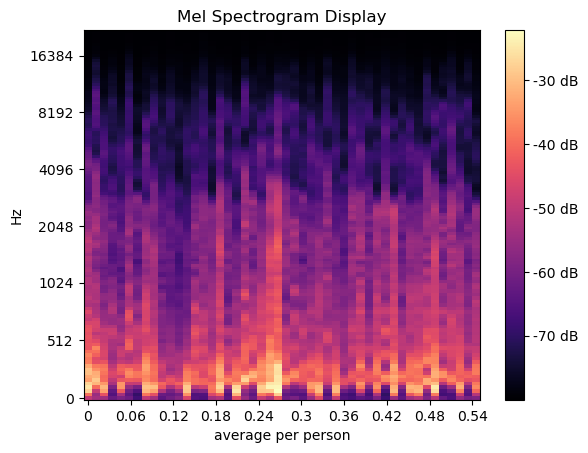

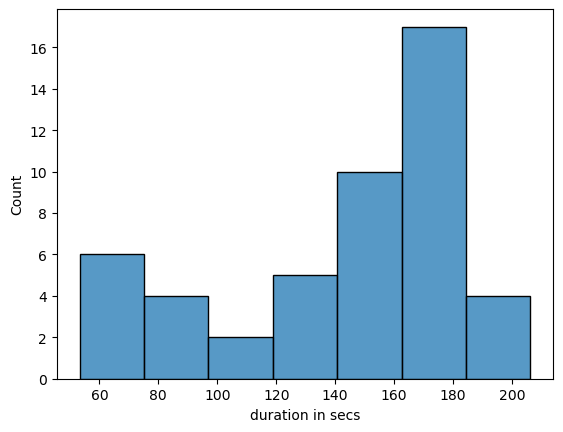

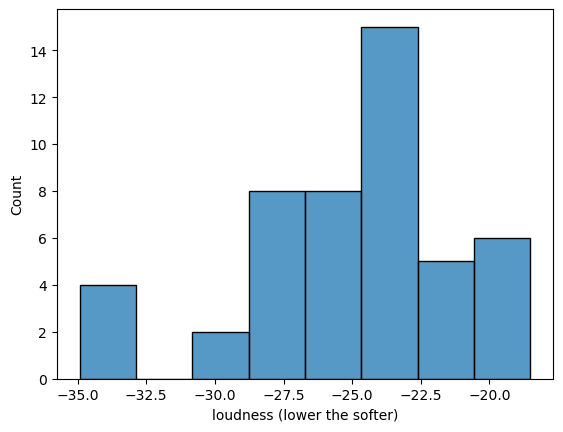

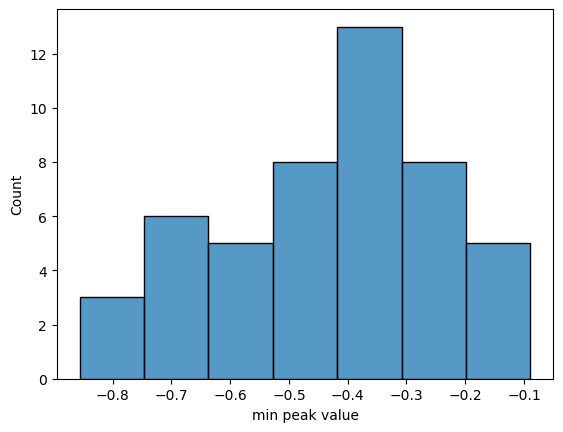

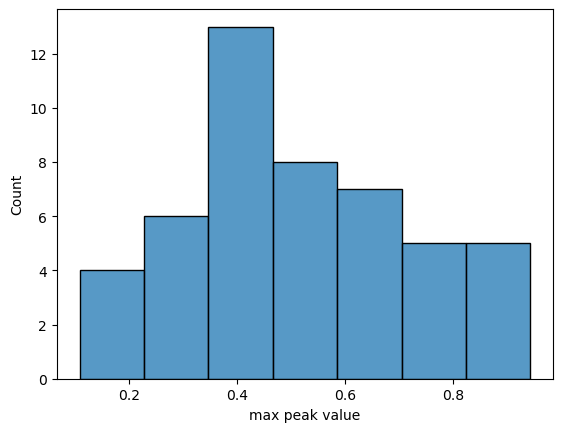

count       48.0
mean     44100.0
std          0.0
min      44100.0
25%      44100.0
50%      44100.0
75%      44100.0
max      44100.0
Name: sr, dtype: float64


In [189]:
nus_interim_path = Path("./data/interim/nus-48e")
analyse_audio(root_path/nus_interim_path)

# Vocalset

100%|██████████| 3613/3613 [02:13<00:00, 27.15it/s]


please ignore x values!


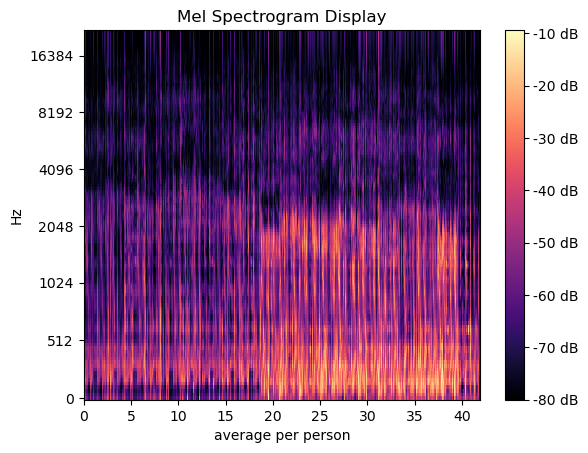

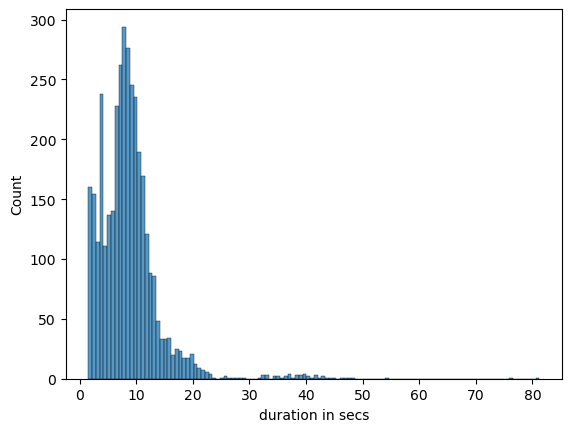

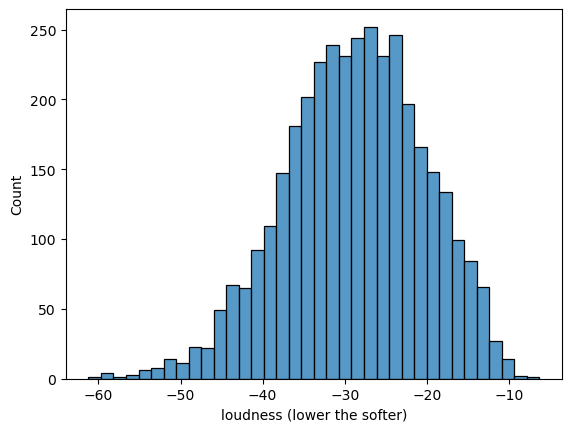

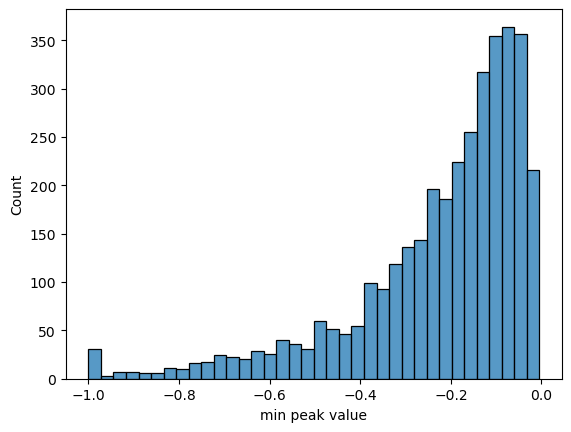

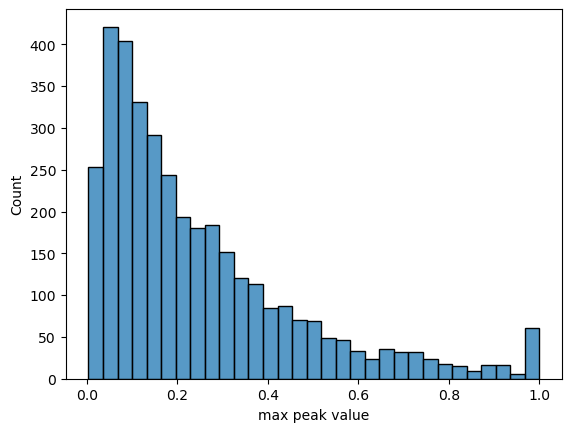

count     3613.0
mean     44100.0
std          0.0
min      44100.0
25%      44100.0
50%      44100.0
75%      44100.0
max      44100.0
Name: sr, dtype: float64


In [190]:
vocalset_interim_path = Path("./data/interim/vocalset")
analyse_audio(root_path/vocalset_interim_path)

# Comments
- Sample rates
    - both dataset, sample rates are 44100Hz.
- Loudness
    - both dataset, audio amplitude will need to be normalised, as shown in min max peak values, and general loudness
- Duration
    - for nus, audio lengths are about under 200 secs
    - for vocalset, most of the clips are around 10 secs, with some about 40 secs
- Frequency response
    - audio frequency seems to be concentrated on 200Hz and 2kHz, though male and females will have different frequency response
- Gender distribution
    - Vocal set contains 9 male, and 11 female, we can assume it is a balanced set.
    - the NUS-48e contains 6 male and 6 female subjects as shown in the paper description.
- clip counts
    - NUS-48e only has 48 clips which is small.
    - the vocalset has 3613 clips.

# Ideas for training
- loudness augmentation is possible after normalisation, so the model will be able to respond to differ amplitudes.
- audio clips blocks could be randomly picked from all clips at any time.
- audio clips can be pre-segmented into 1 sec clips, so it can be less taxing the dataloader.
- We can allow silence block for training, as we also want the model to output silence when input is also silence. Therefore there is no need for audio trimings.
- We can use NUS-48e for quick model training and include vocalset for training and evaluation.
- More dataset will be searched and included when we decide on the final model.